In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.models import load_model
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
keras.__version__

'2.1.6'

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def encode(labels):
    '''
    One-hot-encode labels.
    '''
    return to_categorical(labels)

In [5]:
def decode(labels):
    '''
    Decode one-hot-encoded labels.
    '''
    return np.argmax(labels, axis=1)

In [6]:
def plot_metrics(history):
    '''
    Plots metrics returned by keras.CallBacks.History objects.
    Arguments:
        history: dictionary. Keys are metrics and entries are lists of values for each epoch.
    '''
    keys = list(history.keys())
    num_metrics = len(keys)
    fig, axs = plt.subplots(num_metrics, 1, figsize=(5, 5*num_metrics))
    fig.subplots_adjust(hspace=0.2)
    for i, key in enumerate(keys):
        y = history[key]
        x = range(1, len(y)+1)
        axs[i].plot(x, y)
        axs[i].set(ylabel=key)
        axs[i].set_xticks(x)
        yticks = np.arange(min(y), max(y), (max(y)-min(y))/10)
        axs[i].set_yticks(yticks)
    plt.xlabel('Epochs')

In [7]:
def plot_images(images, labels, predictions, classes=None, correct=True, incorrect=True):
    '''
    plot_images(images, labels, predictions, classes=None, correct=True, incorrect=True)
    Plots images with labels.
    Arguments:
        images: list of images.
        labels: list or array. True labels of images, must have length equal to 0 dimension of images.
        predictions: list or array. Predicted labels for images, must have length equal to 0 dimension of images.
        classes: list of str. Optional. Word labels for images.
        correct: bool. If True, images where true and predicted label match will be displayed.
        incorrect: bool. If True, images where true and predicted label do not match will be displayed.
    '''
    labels = np.asarray(labels)
    predictions = np.asarray(predictions)
    corr_pred = (labels == predictions)
    length = 0
    cut = 0
    if correct:
        length += np.count_nonzero(corr_pred)
        cut += length
    if incorrect:
        length += np.size(corr_pred) - np.count_nonzero(corr_pred)
    fig, axs = plt.subplots(length, 1, figsize=(5, 5*length))
    correct_idx = np.where(corr_pred)[0]
    incorrect_idx = np.where(corr_pred == False)[0]

    for i, ax in enumerate(axs[:cut]):
        idx = correct_idx[i]
        if correct and corr_pred[idx]:
            title = 'Correctly predicted as '+ classes[labels[idx]] if classes else 'Correctly guessed'
            ax.imshow(images[idx])
            ax.set_title(title)
            ax.set_axis_off()

    for i, ax in enumerate(axs[cut:]):
        idx = incorrect_idx[i]
        if incorrect and (not corr_pred[idx]):
            title = classes[labels[idx]]+' but predicted '+classes[predictions[idx]] if classes else 'Incorrectly predicted'
            ax.imshow(images[idx])
            ax.set_title(title)
            ax.set_axis_off()

# Fine-tune VGG16 to classify 3 classes of BENTHOZ-2015. 

## Preprocess input

In [8]:
train_path = '/Users/diegoeduardo/Desktop/Coral Reef Data/annotated images/train'
valid_path = '/Users/diegoeduardo/Desktop/Coral Reef Data/annotated images/valid'
test_path = '/Users/diegoeduardo/Desktop/Coral Reef Data/annotated images/test'

Classes with 1000+ examples: ['45', '67', '59', '400', '54', '71', '64', '68', '65', '241', '253', '245', '2', '127', '28', '16', '27','22', '26', '33', '166']

In [9]:
classes = ['239', '150', '64']

In [10]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224, 224), classes=classes, batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224, 224), classes=classes, batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224, 224), classes=classes, batch_size=100)

Found 2303 images belonging to 3 classes.
Found 492 images belonging to 3 classes.
Found 493 images belonging to 3 classes.


## Build CNN from VGG16

In [11]:
vgg16_model_temp = keras.applications.vgg16.VGG16()
vgg16_model = Sequential()
for layer in vgg16_model_temp.layers[:-1]:
    vgg16_model.add(layer)
del vgg16_model_temp
for layer in vgg16_model.layers:
    layer.trainable = False
vgg16_model.add(Dense(len(classes), activation='softmax'))

In [12]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Train

In [13]:
learning_rate = 1e-3
steps_per_epoch = 10
epochs = 10
vgg16_model.compile(Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
history = vgg16_model.fit_generator(train_batches, steps_per_epoch=steps_per_epoch, 
                                    epochs=epochs, validation_data=valid_batches, verbose=1)

Epoch 1/10
10/10 [==============================] - 219s 22s/step - loss: 0.8753 - acc: 0.6100 - val_loss: 0.5725 - val_acc: 0.7825
Epoch 2/10
10/10 [==============================] - 231s 23s/step - loss: 0.3893 - acc: 0.8300 - val_loss: 0.4851 - val_acc: 0.8333
Epoch 3/10
10/10 [==============================] - 220s 22s/step - loss: 0.5251 - acc: 0.8100 - val_loss: 0.4662 - val_acc: 0.8191
Epoch 4/10
10/10 [==============================] - 220s 22s/step - loss: 0.2199 - acc: 0.9295 - val_loss: 0.4154 - val_acc: 0.8598
Epoch 5/10
10/10 [==============================] - 222s 22s/step - loss: 0.3284 - acc: 0.8400 - val_loss: 0.3443 - val_acc: 0.8801
Epoch 6/10
10/10 [==============================] - 222s 22s/step - loss: 0.4649 - acc: 0.8900 - val_loss: 0.4263 - val_acc: 0.8354
Epoch 7/10
10/10 [==============================] - 222s 22s/step - loss: 0.3211 - acc: 0.8800 - val_loss: 0.3411 - val_acc: 0.8821
Epoch 8/10
10/10 [==============================] - 222s 22s/step - loss: 0.

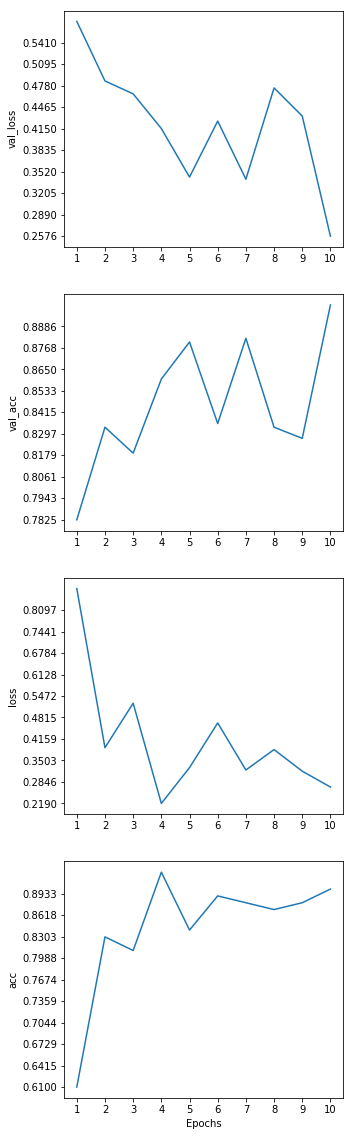

In [14]:
plot_metrics(history.history)

In [15]:
vgg16_model.save('/Users/diegoeduardo/Desktop/Coral Reef Data/models/july_10_7pm_classes(239_150_64).h5')

## Test

In [ ]:
#Retrieve model if re-opening notebook
vgg16_model = load_model('/Users/diegoeduardo/Desktop/Coral Reef Data/models/july_10_7pm_classes(239_150_64).h5')

In [16]:
test_imgs, test_labels = next(test_batches)
test_labels = decode(test_labels)
predictions = vgg16_model.predict_generator(test_batches, steps=1, verbose=0)
predictions = decode(predictions)

Normalized confusion matrix
[[0.88       0.04       0.08      ]
 [0.15384615 0.80769231 0.03846154]
 [0.08163265 0.         0.91836735]]


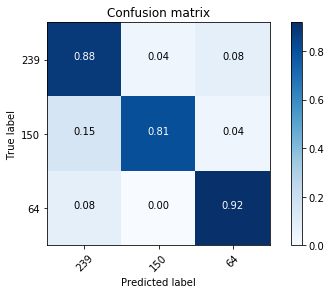

In [17]:
cm = confusion_matrix(test_labels, predictions)
cm_plot_labels = classes
plot_confusion_matrix(cm, cm_plot_labels, normalize=True, title='Confusion matrix')

#### ID interpretations:
    239: Substrate
    150: Cnidaria: Corals: Black & Octocorals: Fan (2D): Fern-frond: Complex
    64:  Macroalgae: Erect coarse branching: Green

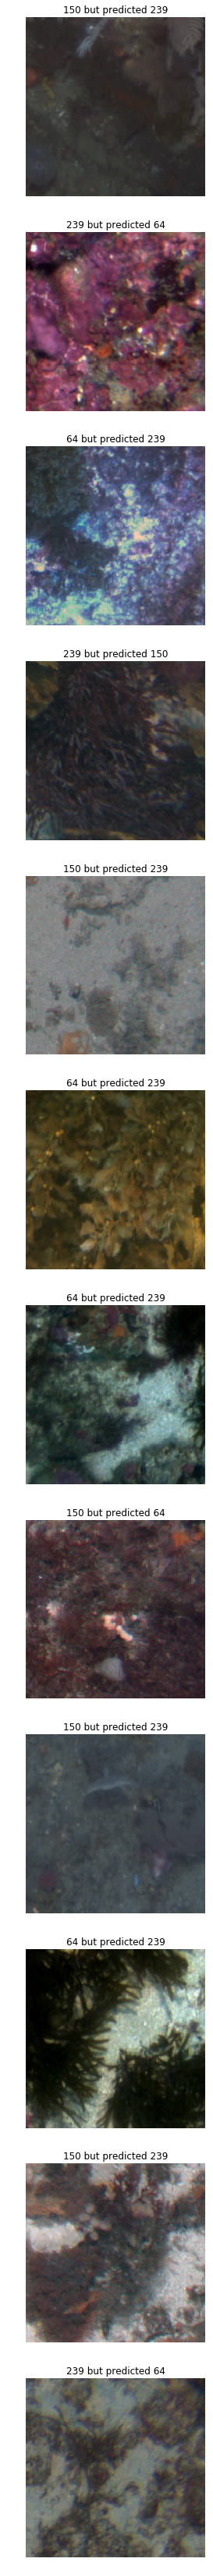

In [18]:
test_imgs_rescaled = test_imgs/255
ls_test_imgs = list(test_imgs_rescaled)
plot_images(ls_test_imgs, test_labels, predictions, classes=classes, correct=False, incorrect=True)